# Vehicle Detection


## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
# Define all imports upfront
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time


# Our utils
from im_utils import read_cv2_image, read_mpimg
from transforms import bin_spatial, extract_features, color_hist, get_hog_features, find_cars

## Step1 - Data Exploration

In [2]:
vehicle_paths = glob.glob('dataset/vehicles/**/*.png')
non_vehicle_paths =  glob.glob('dataset/non-vehicles/**/*.png')

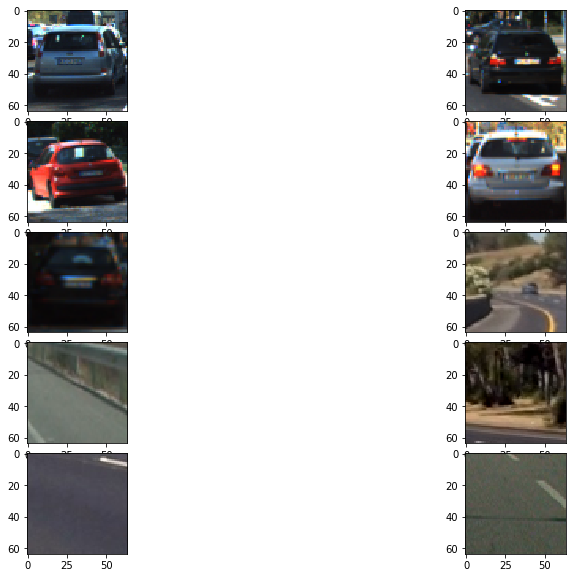

In [3]:
def get_random_vehicle_images(num):
    images = []
    rand_vehicle_indices = random.sample(range(len(vehicle_paths)), num)
    for i in rand_vehicle_indices:
        images.append(read_mpimg(vehicle_paths[i]))
    return images

def get_random_non_vehicle_images(num):
    images = []
    rand_non_car_indices = random.sample(range(len(non_vehicle_paths)), num)
    for i in rand_non_car_indices:
        images.append(read_mpimg(non_vehicle_paths[i]))
    return images
    
    
def explore_images():
    images = get_random_vehicle_images(5)
    images.extend(get_random_non_vehicle_images(5))    
    fig, axs = plt.subplots(5, 2, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(10):
        img = images[i]
        axs[i].imshow(img)
                             
explore_images()                             

## Step2 - Transformations and training pipeline

### Step2.1 - Visualize Hog transformation

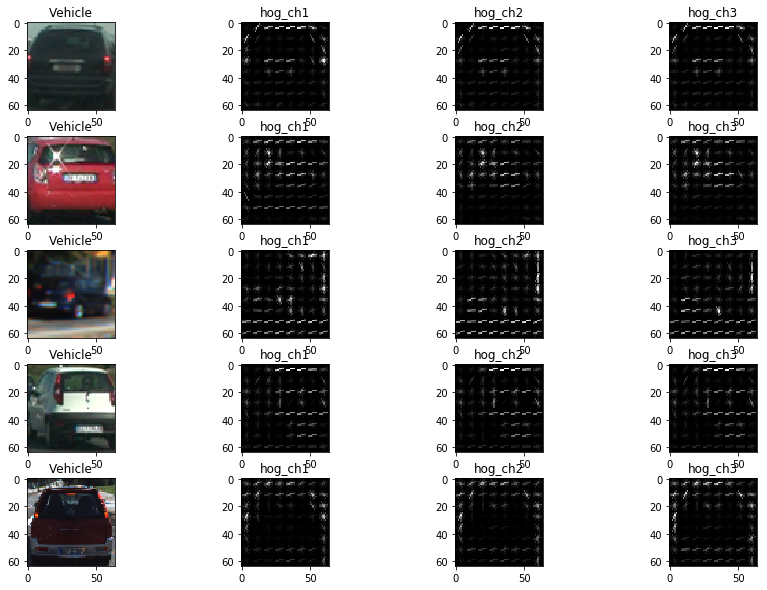

In [4]:
# Get some reandom images and run them against `get_hog_features` method with 
# visualization and see how our tranform is working
random_vehicles = get_random_vehicle_images(5)
fig, axs = plt.subplots(5, 4, figsize=(15, 10))
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()

i = 0

orient=9 
pix_per_cell=8
cell_per_block=2

while i < 20:
    vehicle = random_vehicles[int(i/4)]
    _, hog_ch1 = get_hog_features(vehicle[:,:,0], 
                                  orient=orient, 
                                  pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, vis=True, feature_vec=True)
    _, hog_ch2 = get_hog_features(vehicle[:,:,1], 
                                  orient=orient, 
                                  pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, vis=True, feature_vec=True)
    _, hog_ch3 = get_hog_features(vehicle[:,:,2], 
                                  orient=orient, 
                                  pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, vis=True, feature_vec=True)
    
    axs[i].imshow(vehicle)
    axs[i].set_title('Vehicle')    
    i +=1
    
    axs[i].imshow(hog_ch1,  cmap='gray')
    axs[i].set_title('hog_ch1')
    i +=1
    
    axs[i].imshow(hog_ch2,  cmap='gray')
    axs[i].set_title('hog_ch2')
    i +=1
    
    axs[i].imshow(hog_ch3, cmap='gray')
    axs[i].set_title('hog_ch3')
    i +=1

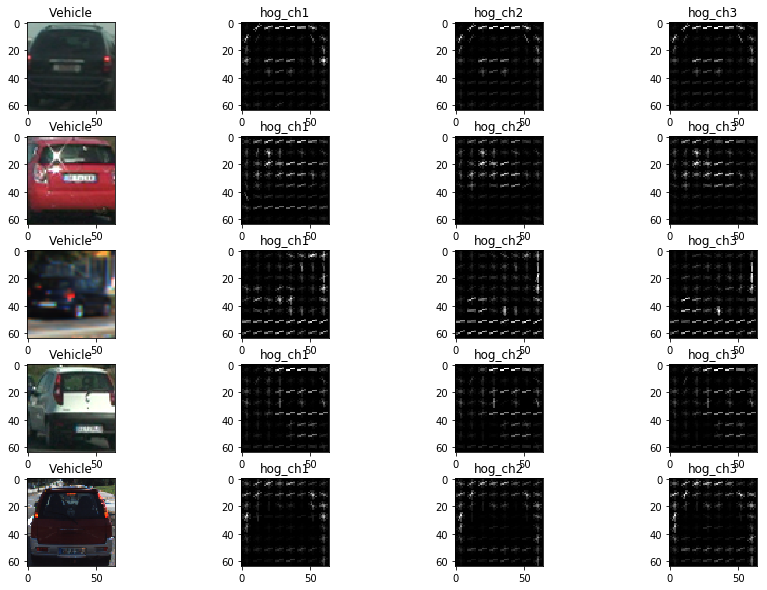

In [5]:
# Different orientation

fig, axs = plt.subplots(5, 4, figsize=(15, 10))
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()

i = 0

orient=11 
pix_per_cell=8
cell_per_block=2

while i < 20:
    vehicle = random_vehicles[int(i/4)]
    _, hog_ch1 = get_hog_features(vehicle[:,:,0], 
                                  orient=orient, 
                                  pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, vis=True, feature_vec=True)
    _, hog_ch2 = get_hog_features(vehicle[:,:,1], 
                                  orient=orient, 
                                  pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, vis=True, feature_vec=True)
    _, hog_ch3 = get_hog_features(vehicle[:,:,2], 
                                  orient=orient, 
                                  pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, vis=True, feature_vec=True)
    
    axs[i].imshow(vehicle)
    axs[i].set_title('Vehicle')    
    i +=1
    
    axs[i].imshow(hog_ch1,  cmap='gray')
    axs[i].set_title('hog_ch1')
    i +=1
    
    axs[i].imshow(hog_ch2,  cmap='gray')
    axs[i].set_title('hog_ch2')
    i +=1
    
    axs[i].imshow(hog_ch3, cmap='gray')
    axs[i].set_title('hog_ch3')
    i +=1

### Step 2.2 - Define a Tranining Pipeline

Here I define `training_pipeline` function which 
1. Constructs feature and label vectors from car and non car test image set
2. Performs feature normalization using `StandardScaler` from sklearn
3. Using `train_test_split` from sklearn split data into training and validation sets
4. Using `LinearSVC` as suggested in class train the model
5. Method returns a tuple => (model, accuracy, training_time, X_scaler)

In [6]:
def training_pipeline(test_car_images, test_non_car_images,
                     cspace='RGB', spatial_size=(32, 32),
                     spatial_transform=True, hist_transform=True, hist_bins=32,
                     hog_transform=True, pix_per_cell=8, cell_per_block=2, orient=9,
                     hog_channel='ALL'):
    
    start_time=time.time()
    car_features = extract_features(test_car_images, cspace=cspace, spatial_size=spatial_size,
                                    spatial_transform=spatial_transform, hist_transform=hist_transform, 
                                    hist_bins=hist_bins, hog_transform=hog_transform, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    orient=orient, hog_channel=hog_channel)

    not_car_features = extract_features(test_non_car_images, cspace=cspace, spatial_size=spatial_size,
                                    spatial_transform=spatial_transform, hist_transform=hist_transform, 
                                    hist_bins=hist_bins, hog_transform=hog_transform, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    orient=orient, hog_channel=hog_channel)

    # Stack feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float64)                        

    # Combine car and non labels into one feature vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
    
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # Shuffle and split data to training and test. 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

    svc = LinearSVC()
    svc.fit(X_train, y_train)
    
    # Compute training time
    training_time=round(time.time()-start_time, 3)
    
    # Get training accuracy
    training_accuracy=round(svc.score(X_test, y_test), 3)
    
    return (svc, training_accuracy, training_time, X_scaler)
    

In [7]:
vehicle_images = []
non_vehicle_images = []
for i in range(len(vehicle_paths)):
        vehicle_images.append(read_mpimg(vehicle_paths[i]))

for i in range(len(non_vehicle_paths)):
        non_vehicle_images.append(read_mpimg(non_vehicle_paths[i]))

print("Number of vehicle images:", len(vehicle_images))        
print("Number of non vehicle images:", len(non_vehicle_images)) 

Number of vehicle images: 8792
Number of non vehicle images: 8968


### Step 2.3 - Test various parameter configurations


In [8]:
def test_parameters(option_dict):
    cspace=option_dict.get('cspace','RGB')
    spatial_size=option_dict.get('spatial_size',(32, 32))
    spatial_transform=option_dict.get('spatial_transform', True)
    
    hist_transform=option_dict.get('hist_transform', True)
    hist_bins=option_dict.get('hist_bins',32)
    
    hog_transform=option_dict.get('hog_transform',True)
    orient=option_dict.get('orient', 9)
    pix_per_cell=option_dict.get('pix_per_cell', 8)
    cell_per_block=option_dict.get('cell_per_block',2)
    hog_channel=option_dict.get('hog_channel', 1)
    
    _, training_accuracy, training_time, _ = training_pipeline(vehicle_images, non_vehicle_images,
                     cspace=cspace, spatial_size=spatial_size,
                     spatial_transform=spatial_transform, hist_transform=hist_transform, hist_bins=hist_bins,
                     hog_transform=hog_transform, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                     orient=orient, hog_channel=hog_channel)
    
    print("Option dict \n", option_dict)
    print("Training accuracy {}, Training time {} seconds".format(training_accuracy, training_time))


In [9]:
    
print("===================================== Config: 1 =======================================")
test_parameters({
    'cspace': 'RGB',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Config: 1 =======================================
Option dict 
 {'pix_per_cell': 8, 'hist_bins': 32, 'cell_per_block': 2, 'spatial_transform': True, 'hog_transform': True, 'cspace': 'RGB', 'hog_channel': 'ALL', 'spatial_size': (32, 32), 'orient': 9, 'hist_transform': True}
Training accuracy 0.983, Training time 107.529 seconds


In [15]:
print("===================================== Config: 2 =======================================")
# Accuracy is good but takes a while for training
test_parameters({
    'cspace': 'YCrCb',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Config: 2 =======================================
Option dict {'pix_per_cell': 8, 'spatial_size': (32, 32), 'hist_transform': True, 'cell_per_block': 2, 'cspace': 'YCrCb', 'hist_bins': 32, 'hog_transform': True, 'hog_channel': 'ALL', 'spatial_transform': True, 'orient': 9}
Training accuracy 0.984, Training time 101.812 seconds


In [17]:
print("===================================== Config: 3 =======================================")
# Use only 1 hog channel to see how much time i can save. You can see below, this is much faster but accuracy goes down
test_parameters({
    'cspace': 'YCrCb',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 1
})

===================================== Config: 3 =======================================
Option dict {'pix_per_cell': 8, 'spatial_size': (32, 32), 'hist_transform': True, 'cell_per_block': 2, 'cspace': 'YCrCb', 'hist_bins': 32, 'hog_transform': True, 'hog_channel': 1, 'spatial_transform': True, 'orient': 9}
Training accuracy 0.981, Training time 44.079 seconds


In [18]:
print("===================================== Config: 4 =======================================")
# Use only 1 hog channel and try YUV color space
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 1
})

===================================== Config: 4 =======================================
Option dict {'pix_per_cell': 8, 'spatial_size': (32, 32), 'hist_transform': True, 'cell_per_block': 2, 'cspace': 'YUV', 'hist_bins': 32, 'hog_transform': True, 'hog_channel': 1, 'spatial_transform': True, 'orient': 9}
Training accuracy 0.979, Training time 45.511 seconds


In [10]:
print("===================================== Config: 5 =======================================")
# Use all 3 hog channels with YUV color space. As you can see, this is reasonably faster and best accuracy so far.
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Config: 5 =======================================
Option dict 
 {'pix_per_cell': 8, 'hist_bins': 32, 'cell_per_block': 2, 'spatial_transform': True, 'hog_transform': True, 'cspace': 'YUV', 'hog_channel': 'ALL', 'spatial_size': (32, 32), 'orient': 9, 'hist_transform': True}
Training accuracy 0.991, Training time 99.14 seconds


In [23]:
print("===================================== Config: 6 =======================================")
# Use all 3 hog channels with YUV color space. Increase orient. This increased time slightly with no gain in accuracy
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 11,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Config: 6 =======================================
Option dict {'pix_per_cell': 8, 'spatial_size': (32, 32), 'hist_transform': True, 'cell_per_block': 2, 'cspace': 'YUV', 'hist_bins': 32, 'hog_transform': True, 'hog_channel': 'ALL', 'spatial_transform': True, 'orient': 11}
Training accuracy 0.99, Training time 85.064 seconds


In [24]:
print("===================================== Config: 7 =======================================")
# Use config 5 above and see if we can remove spatial bin keeping accuracy higher or same. Little saving in time but
# accuracy is also went down.
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': False, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Config: 7 =======================================
Option dict {'pix_per_cell': 8, 'spatial_size': (32, 32), 'hist_transform': True, 'cell_per_block': 2, 'cspace': 'YUV', 'hist_bins': 32, 'hog_transform': True, 'hog_channel': 'ALL', 'spatial_transform': False, 'orient': 9}
Training accuracy 0.989, Training time 80.621 seconds


In [25]:
print("===================================== Config: 8 =======================================")
# Use config 5 above and see if we can remove hist bin keeping accuracy higher or same. No saving in time but
# accuracy is also went down.
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': False,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Config: 8 =======================================
Option dict {'pix_per_cell': 8, 'spatial_size': (32, 32), 'hist_transform': False, 'cell_per_block': 2, 'cspace': 'YUV', 'hist_bins': 32, 'hog_transform': True, 'hog_channel': 'ALL', 'spatial_transform': True, 'orient': 9}
Training accuracy 0.988, Training time 86.425 seconds


## Step 3 - Implement a sliding-window technique to search for vehicles in images.

### Step 3.1 Explore image size. 

To help us figure out where to chope image



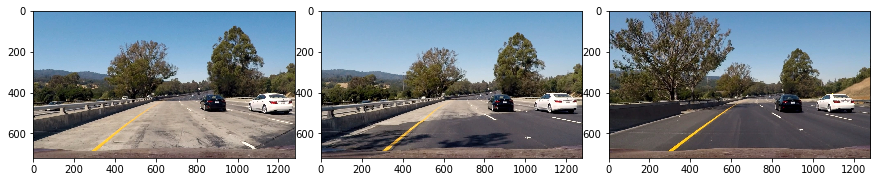

In [9]:
test_image_paths = glob.glob('test_images/*.jpg')
test_images = []
for test_image_path in test_image_paths:
        test_images.append(read_mpimg(test_image_path))
        
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()
axs[0].imshow(test_images[0])
axs[1].imshow(test_images[3])
axs[2].imshow(test_images[5])

### Step 3.2 - Define final model feature parameters

In [10]:
# Based on experiments above I chose config 5
final_cspace='YUV'
final_spatial_size=(32, 32)
final_spatial_transform= True
final_hist_transform= True
final_hist_bins= 32
final_hog_transform= True
final_orient= 9
final_pix_per_cell= 8
final_cell_per_block= 2
final_hog_channel= 'ALL'

final_svc, final_svc_accuracy, _, X_scaler = training_pipeline(vehicle_images, non_vehicle_images,
                     cspace=final_cspace, 
                     spatial_size=final_spatial_size,
                     spatial_transform=final_spatial_transform, 
                     hist_transform=final_hist_transform, 
                     hist_bins=final_hist_bins,
                     hog_transform=final_hog_transform, 
                     pix_per_cell=final_pix_per_cell, 
                     cell_per_block=final_cell_per_block, 
                     orient=final_orient, 
                     hog_channel=final_hog_channel)

print("Final training accuracy {}".format(final_svc_accuracy))

Final training accuracy 0.99


### Step 3.3 - Utility methods to draw bounding boxes, heatmaps, applying threshold

In [38]:
def draw_bounding_boxes(img, bounding_boxes, color=(0,0,255)):
    draw_img = np.copy(img)
    for bounding_box in bounding_boxes:
        cv2.rectangle(draw_img,(bounding_box[0][0], bounding_box[0][1]),
                      (bounding_box[1][0], bounding_box[1][1]),color,6)
    return draw_img

# This is copied from lesson with slight modification
def add_heat(heatmap, bounding_boxes):
    # Iterate through list of bboxes
    draw_img = np.copy(heatmap)
    for bounding_box in bounding_boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        draw_img[bounding_box[0][1]:bounding_box[1][1], bounding_box[0][0]:bounding_box[1][0]] += 1

    # Return updated heatmap
    return draw_img

# This is copied from lesson with slight modification
def apply_threshold(heatmap, threshold):
    draw_img = np.copy(heatmap)
    # Zero out pixels below the threshold
    draw_img[heatmap <= threshold] = 0
    # Return thresholded map
    return draw_img

### Step 3.4 - Run Sliding search on test images

In [64]:
def run_sliding_window_test(scales):
    display_images = []
    num_random_images = len(test_images)
    for random_test_image in test_images:
        final_all_boxes = []
        final_car_boxes = []
        for ystart, ystop, scale in scales:
            all_boxes, car_boxes = find_cars(random_test_image, ystart, ystop,
                          scale, final_svc, X_scaler, final_orient,
                          final_pix_per_cell, final_cell_per_block,
                          final_cspace, hog_channel=final_hog_channel,
                          spatial_size=final_spatial_size,
                          hist_bins=final_hist_bins
                          )
            final_all_boxes.extend(all_boxes)
            final_car_boxes.extend(car_boxes)
            
        out_img = draw_bounding_boxes(random_test_image, final_all_boxes, color=(0,0,255))
        out_img = draw_bounding_boxes(out_img, final_car_boxes, color=(0,255,0))
        heat = np.zeros_like(random_test_image[:,:,0]).astype(np.float)
        heatmap = add_heat(heat, final_car_boxes)
        heatmap_thr = apply_threshold(heatmap, 2)

        display_images.append(random_test_image)
        display_images.append(out_img)
        display_images.append(heatmap)
        display_images.append(heatmap_thr)

    fig, axs = plt.subplots(num_random_images, 4, figsize=(15, 20))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(num_random_images * 4):
        axs[i].imshow(display_images[i])
        if i % 4 == 0:
            axs[i].set_title("Original image")
        if i % 4 == 1:
            axs[i].set_title("Sliding windows")
        if i % 4 == 2:
            axs[i].set_title("Heat map")
        if i % 4 == 3:
            axs[i].set_title("Threshold")            

Just running one scale (430, 680, 2)


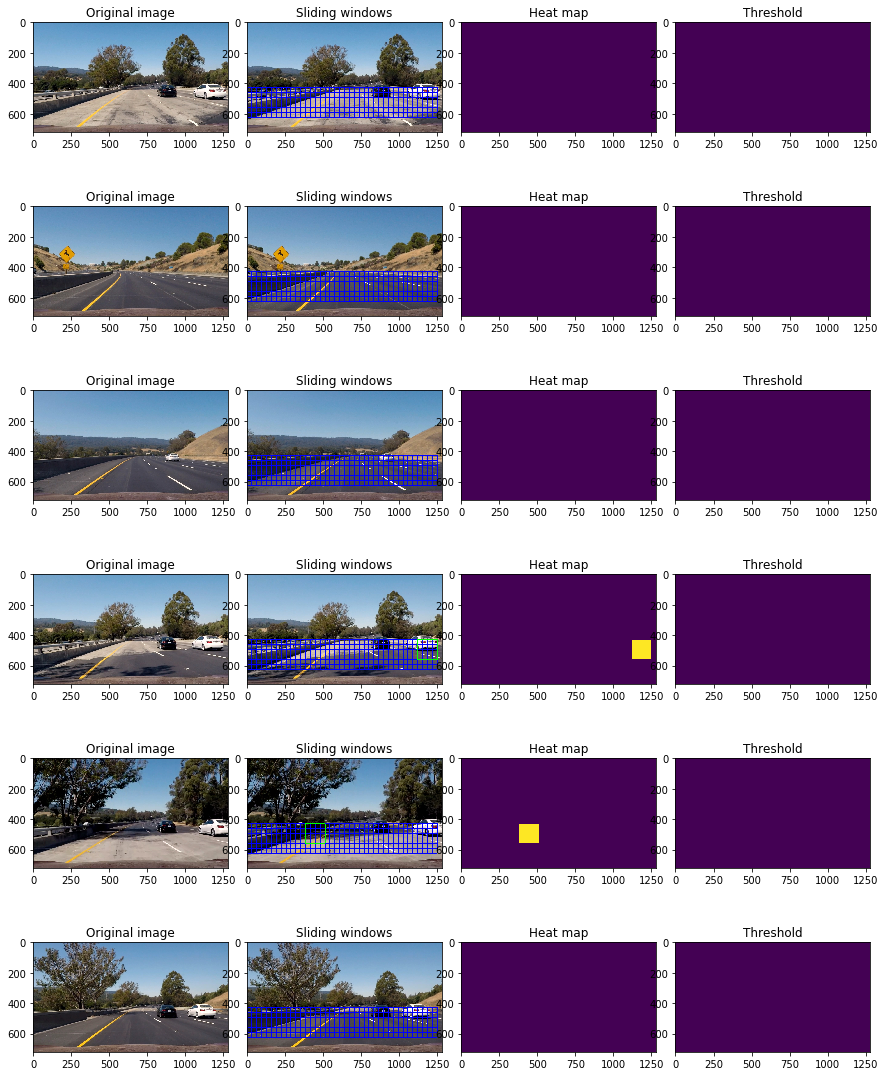

In [65]:
# At bottom of image, cars are bigger. Try bigger scale
print("Just running one scale (430, 680, 2)")
run_sliding_window_test([(430, 680, 2)])

Just running one scale (400, 610, 1.75)


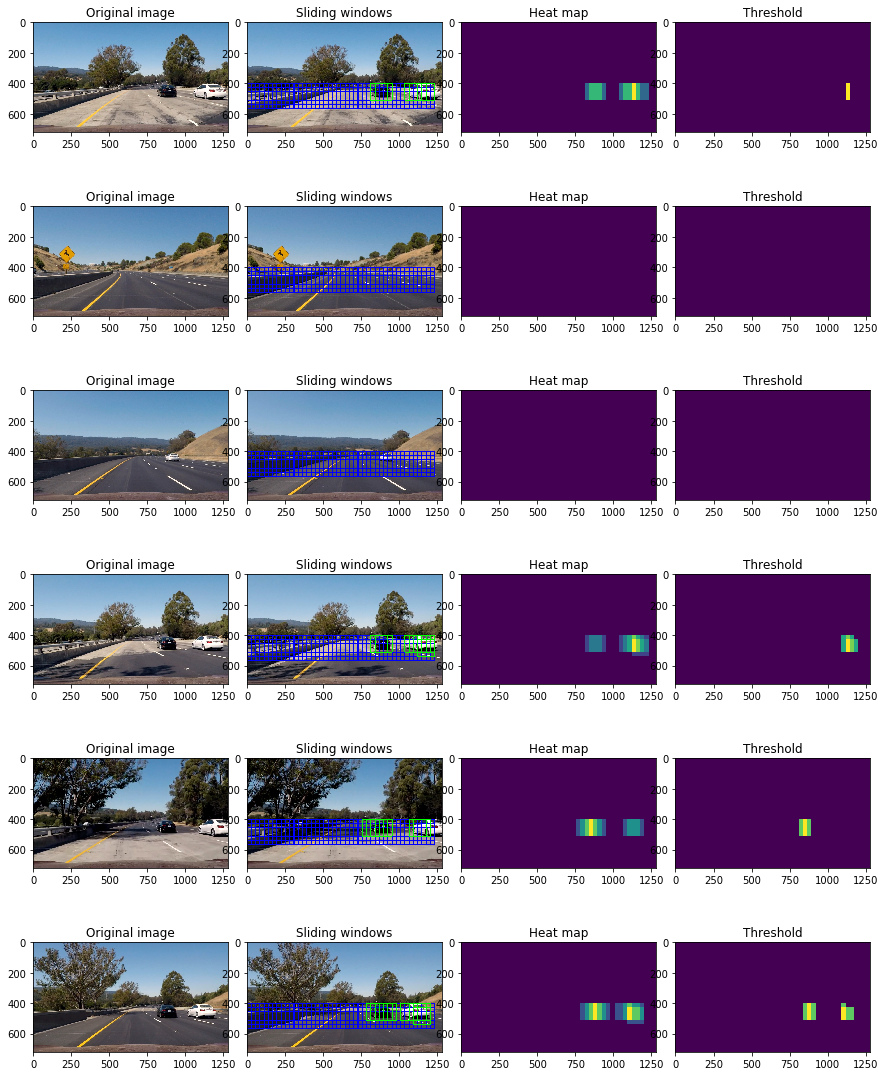

In [66]:
# At slighly mid range, cars are mid-size (in picture). Try smaller scale
print("Just running one scale (400, 610, 1.75)")
run_sliding_window_test([(400, 610, 1.75)])

Just running one scale (360, 560, 1.5)


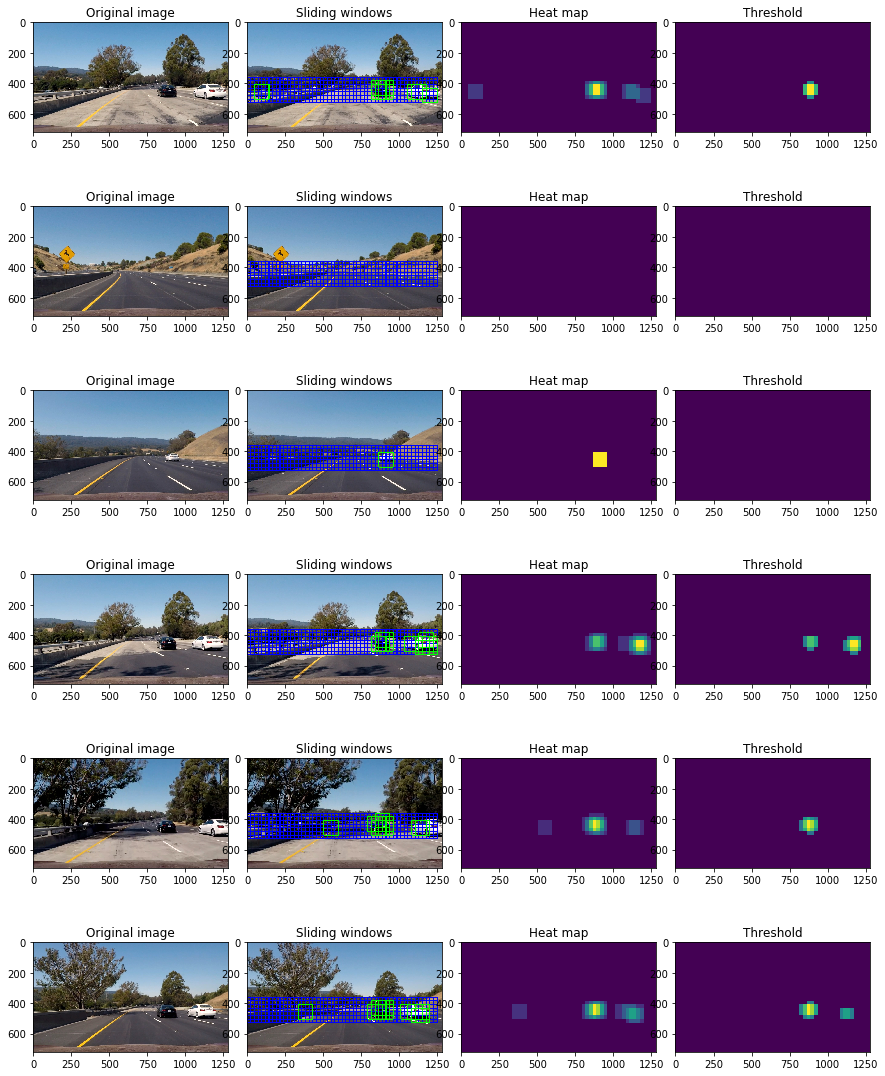

In [67]:
# At mid to top, cars are tiny (in picture). Try smaller scale
print("Just running one scale (360, 560, 1.5)")
run_sliding_window_test([(360, 560, 1.5)])

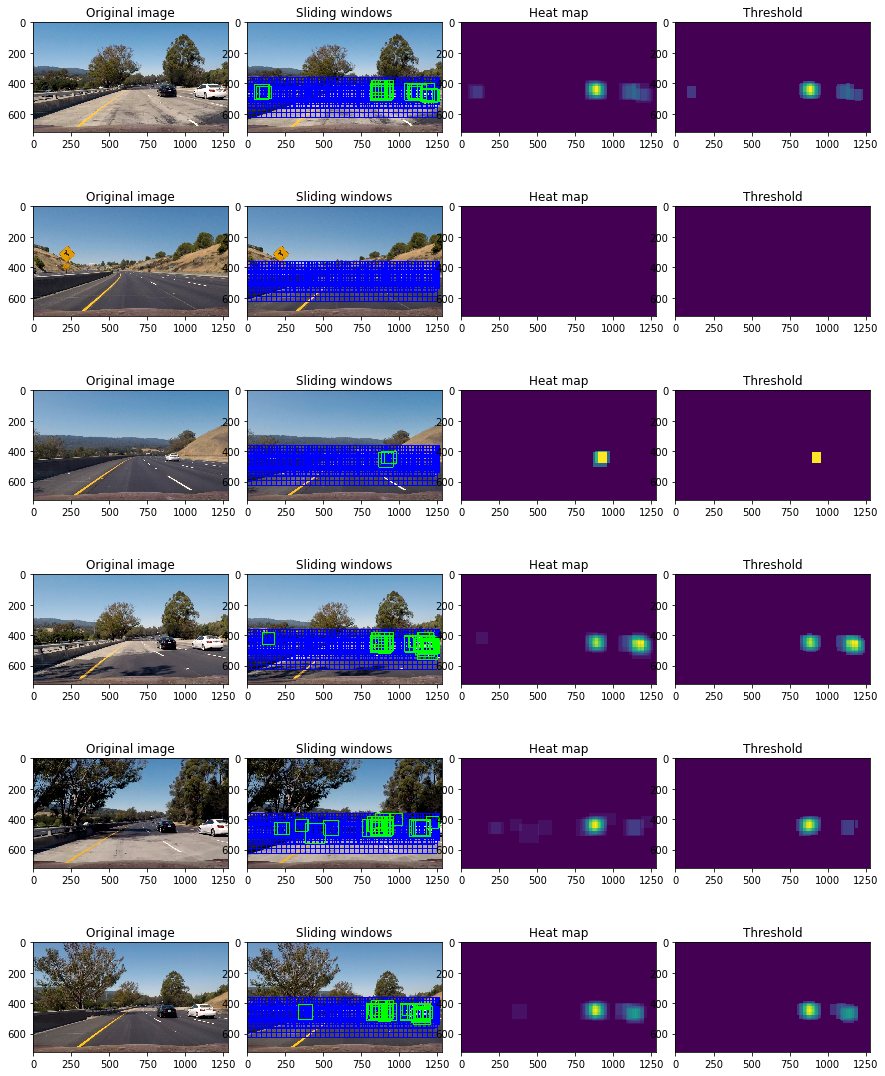

In [68]:
# Run combination of all them
run_sliding_window_test([(430, 680, 2), (400, 610, 1.75), (360, 560, 1.5), (360, 560, 1.25)])

In [69]:
final_scales = [(430, 680, 2), (400, 610, 1.75), (360, 560, 1.5), (360, 560, 1.25)]